In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import datetime

# Time series analysis
In this analysis we aim to predict the `number of accidents` and the `severity of the accidents`.

## Setting up the dataset
It is our intention to create a "found" time series, that is a dataset which is properly cleaned and structured to work with state of the art time series analysis algorithms. The reason for this is that our original Kaggle dataset was not intended to be used for time series analysis and was therefore not organized as such.

In the following, we'll look at the main problems with this dataset, before outlining the strategy we've developed to address them.

### The problem of a messy dataset
The reader should bear in mind that the dataset used is a *government dataset*. As such, due to politics, budgets and other exogenous considerations, missing and inaccurate values, incomplete rows and discontinuities should be expected.

And that's not even the half of it. Given the nature of the dataset we should expect the *time discounting* phenomenom to hinder the accuracy of the recorded information. More specifically, as this is an accident-related dataset, the event is recorded after the intervention of a traffic officer and after a report has been written. This means that the timestamp of the registration is likely to be distant from the timestamp of the accident, and details outside the report may be misreported, due to the *time discounting* phenomenom.

What's more, once we have removed all the columns other than the ones we are interested in analysing, namely `Date`, `Time` and `Accident_Severity`, we notice that there are a few rows with at least one null value in these three columns. To be more precise, we are talking about a total of 156 rows.

To address the latter issue, we have several strategies.

1. **Infer the missing values from other fields by exploiting existing functional dependencies**. For example, if the null value is under the `Date` column, and we can assume that at least one accident occurred every day, we can sort the rows by the `Accident_Index` column and, based on the `Time` field, impute the missing value from the previous or next event.
2. **Interpolate missing values using the previous and next accidents**. For example, if the missing value is under the `Time` column, we can sort the rows by the `Accident_Index` column and assign to the `Time` field the linear interpolation between the two closest accidents. To be even more precise, we can calculate the statistical distribution of the delay between two subsequent events over the entire dataset and then use it to maximise the probability of the missing value. In more practical terms, if the missing value is $y_t$ and the probability density function of the lags inferred from the population is $f_x$, we need to maximize $f(y_t-y_{t-1})+f(y_{t+1}-y_t)$.
   <p align="center">
    <img src="img/delays_distribution.png" width="50%"/>
</p>

3. **Use moving mode to choose the missing value**. For example, if the `Accident_Severity` column is missing a value, we could try to fill it in based on the mode of the *k* preceding values.
4. **Entierly remove the rows in question**. If the rows with missing values are not too many compared to the others, and they don't have any relevance as outliers, we can safely remove them.

### The problem of daylight savings time
<p align="center">
    <img src="img/time_zone.png" width="30%"/>
</p>

As the dataset is based on accidents that took place in the United Kingdom, the problem of time zone mismatch does not arise. In fact, the whole country is in the UTC time zone, so not only do we not have to worry about multiple time zones based on latitude and longitude values, but also we have equivalence between UTC and the local time zone.

However, there's still the problem of daylight savings time, which causes some instants to occur twice a year and others to not exist at all.

In [164]:
DATASET_NAME = 'Accident_Information'
USE_CACHED = True

In [165]:
df_original = pd.read_csv(f'../dataset/{DATASET_NAME}{'[time_series]'if USE_CACHED else ''}.csv', low_memory=False)

In [184]:
df = df_original if USE_CACHED else (
    df_original[['Accident_Severity', 'Date', 'Time',
                 'Number_of_Casualties', 'Number_of_Vehicles']]
    .assign(timestamp=pd.to_datetime(df_original['Date'] + ' ' + df_original['Time']))
    .drop(columns=['Date', 'Time'])
)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df=df.rename({'Number_of_Casualties': 'number_of_casualties',
          'Number_of_Vehicles': 'number_of_vehicles'}, axis='columns')

In [167]:
f'Original size = {df_original.size/1024 **
                   2:.2f} MB', f'Pruned size = {df.size/1024**2:.2f} MB'

('Original size = 7.81 MB', 'Pruned size = 7.81 MB')

In [185]:
print(f'{len(df[df.isnull().any(axis=1)])
         } rows have a null value, so I remove them')
df = df.dropna()

156 rows have a null value, so I remove them


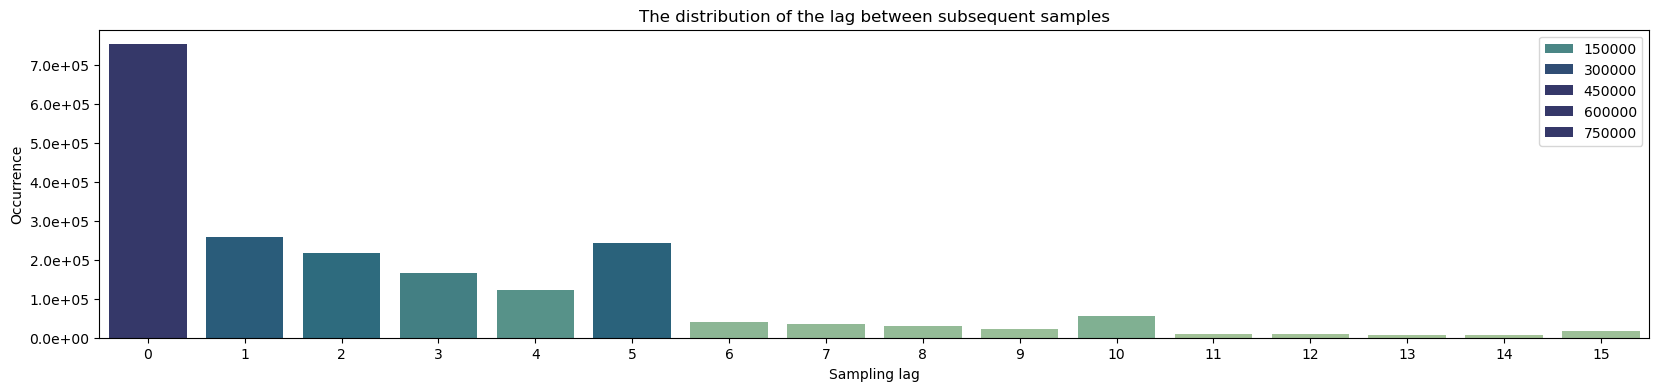

In [186]:
df = df.sort_values(by='timestamp')
df['step'] = (df['timestamp'].diff().dt.total_seconds() / 60).fillna(0)
value_counts = df[df['step'] <= 15]['step'].value_counts().sort_index()

plt.figure(figsize=(20, 4))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='crest', hue=value_counts.values,hue_norm=(1,350000))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1e}'))
plt.title('The distribution of the lag between subsequent samples')
plt.xlabel('Sampling lag')
plt.ylabel('Occurrence')
plt.show()

Here a new problem arises, a large proportion of the events (36.75%) are less than 1 minute apart in different locations in the UK, whereas the granularity of the recording is 1 minute. This means that **these events collapse into a single point in time**.

### Data downsampling through aggregation

We solve most of the problems listed so far by downsampling the data. This choice is justified by the large number of rows in our dataset. In fact, there are 2,047,100 rows with no null values in the columns of interest. The choice is also heavily influenced by the unevenness of the sampling rate, as shown in the previous bar chart.

The time series is therefore downsampled using the *count* aggregation, **daily**, **weekly** and **monthly**. We're careful not to introduce *lookahead*, in the sense that each point should not be aggregated to a new timestamp less than its current one, **to avoid carrying information backwards**. In other words, the number of accidents in a month up to its last day is calculated by counting all the accidents that have occurred since the first day of the very month. 

Following this lead, we'll obtain three datasets, one for each level of aggregation. Each of them will consist of the columns `number_of_accidents`, `number_of_casualties` and `number_of_vehicles`. The distribution of the number of casualties and vehicles involved per accident is shown below.

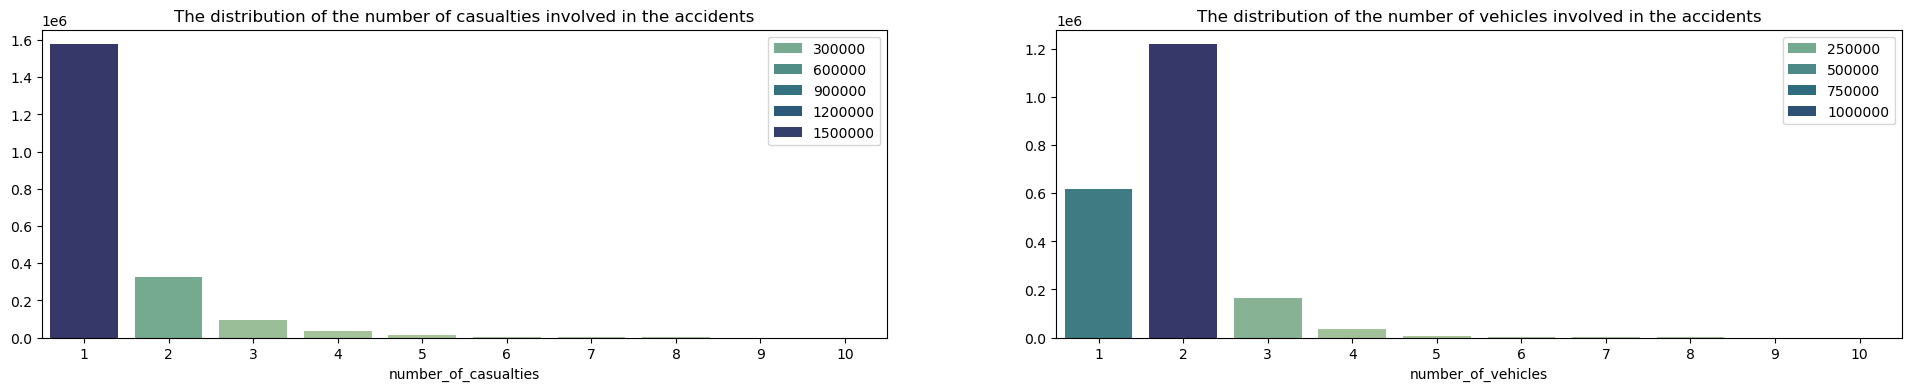

In [ ]:
casualties_counts = df[df['number_of_casualties'] <= 10]['number_of_casualties'].value_counts().sort_index()
vehicles_counts = df[df['number_of_vehicles'] <= 10]['number_of_vehicles'].value_counts().sort_index()
fig, ax=plt.subplots(1,2)
fig.set_size_inches(24,4)
sns.barplot(x=casualties_counts.index, y=casualties_counts.values, palette='crest', hue=casualties_counts.values, ax=ax[0])
sns.barplot(x=vehicles_counts.index, y=vehicles_counts.values, palette='crest', hue=vehicles_counts.values, ax=ax[1])
ax[0].set_title('The distribution of the number of casualties involved in the accidents')
ax[1].set_title('The distribution of the number of vehicles involved in the accidents')
pass

In [443]:
def aggregate(period='M') -> pd.DataFrame:
    df['number_of_accidents'] = 1
    aggregated_df = (
        df.groupby(df['timestamp'].dt.to_period(period))[
            ['number_of_casualties', 'number_of_vehicles', 'number_of_accidents']]
        .sum()
        .reset_index()
        .rename({'timestamp': 'period'}, axis="columns")
    )
    aggregated_df['end_timestamp'] = aggregated_df['period'].dt.end_time.dt.ceil(
        'D')
    return aggregated_df


daily_df = aggregate('D')
weekly_df = aggregate('W')[1:-1]
monthly_df = aggregate('M')
quarterly_df = aggregate('Q')
yearly_df = aggregate('Y')

## Exploratory analysis
We begin our exploratory analysis by plotting the aggregated weekly trend of accidents and casualties.
<!-- 
- plot of 12 TS 1 for each year, and then 1 for each month
- stagionality is additive or multiplicative? Should plot the residuals from the mean
- stationarity, Aug Dickey Fuller (and KPSS?)
- BoxCox
-->

/tmp/ipykernel_35337/3994779100.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


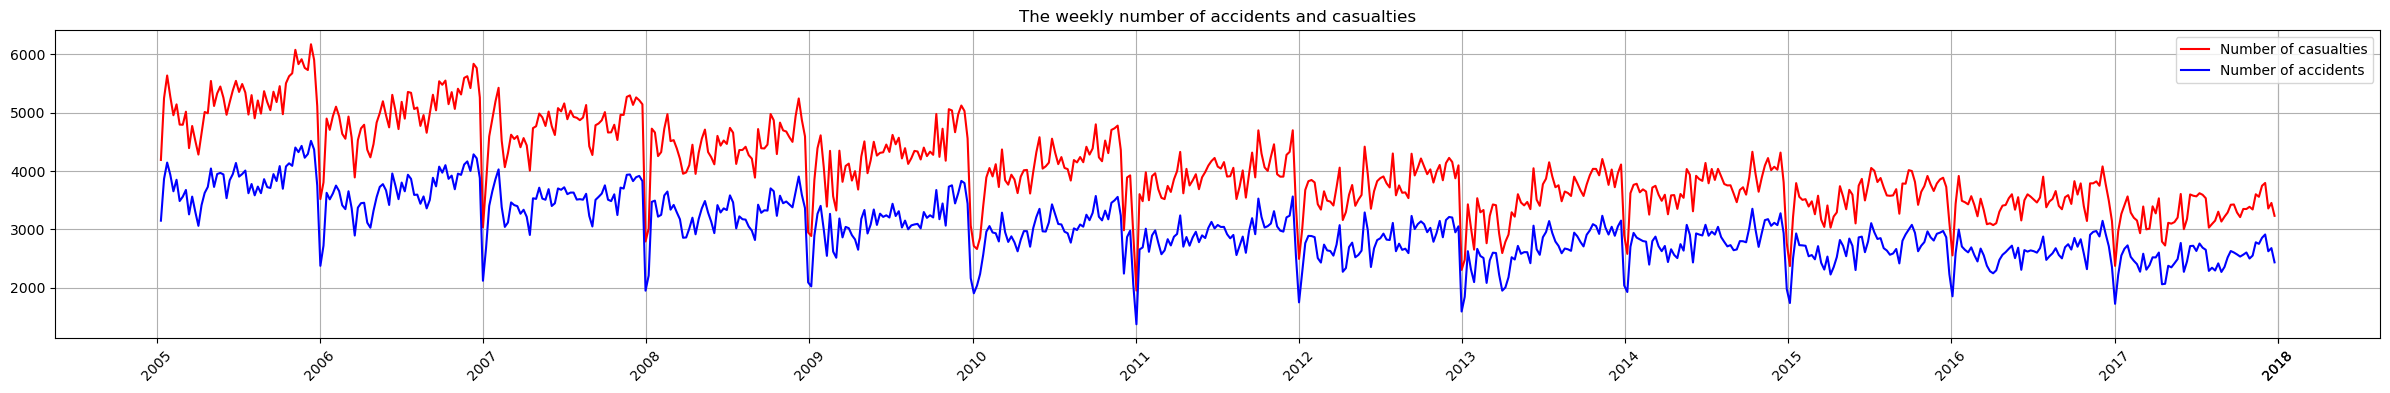

In [324]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(30,4)
ax.plot(weekly_df['end_timestamp'], weekly_df["number_of_casualties"], color="red", label="Number of casualties", linestyle="-")
ax.plot(weekly_df['end_timestamp'], weekly_df["number_of_accidents"], color="blue", label="Number of accidents", linestyle="-")
# ax.plot(yearly_df['end_timestamp'], yearly_df["number_of_casualties"]/52, color="red", label="Number of casualties", linestyle="--", alpha=1)
# ax.plot(yearly_df['end_timestamp'], yearly_df["number_of_accidents"]/52, color="blue", label="Number of accidents", linestyle="--", alpha=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
unique_years = np.sort(np.append(monthly_df['end_timestamp'].dt.year.unique(),2018))
plt.xticks(ticks=pd.to_datetime(unique_years, format='%Y'), labels=unique_years)
plt.title('The weekly number of accidents and casualties')
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_35337/2364632871.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


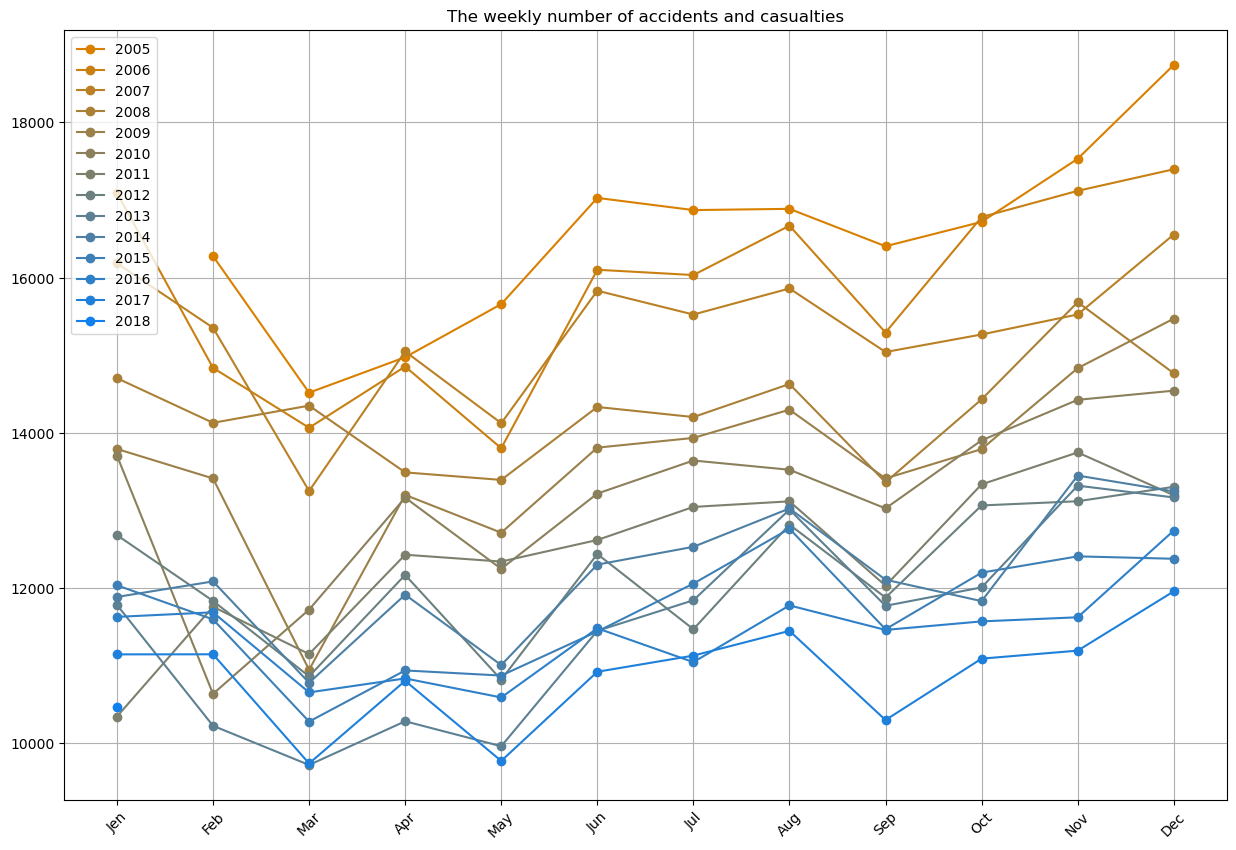

In [ ]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(15,10)

years=monthly_df['end_timestamp'].dt.year.unique()
for i,year in enumerate(years):
    _=monthly_df[monthly_df['end_timestamp'].dt.year==year]
    hue=(i/len(years))
    ax.plot(_['end_timestamp'].dt.month, _["number_of_accidents"], color=(0.85-hue*0.85,0.5,hue), label=f'{year}',marker='o')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(ticks=range(1,13), labels=['Jen','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Per-year month-by-month counts')
plt.legend(loc='upper left')
plt.grid()
plt.show()

/tmp/ipykernel_35337/1720195745.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


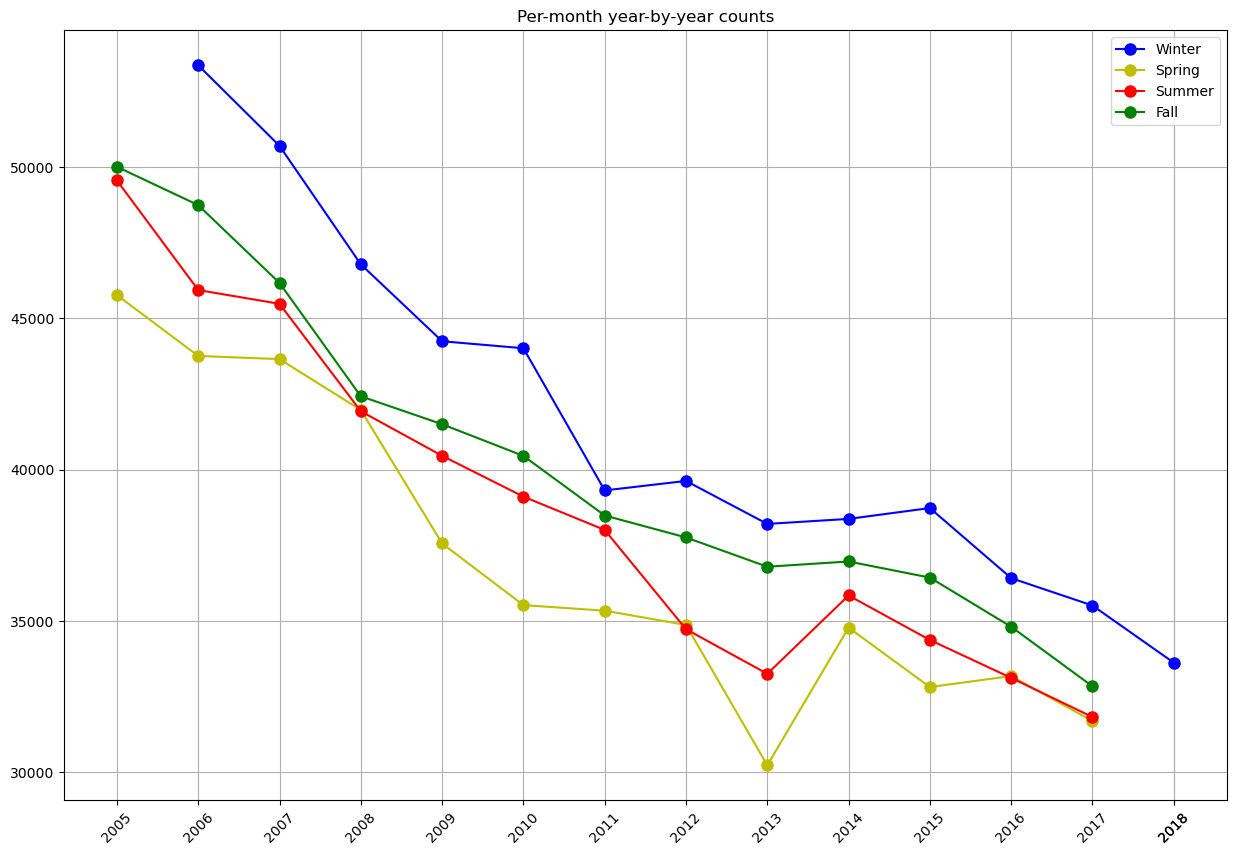

In [464]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(15, 10)

for i, months in enumerate([[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
    _ = quarterly_df[quarterly_df['end_timestamp'].dt.month.isin(months)]
    hue = (i/4)
    ax.plot(_['end_timestamp'].dt.year, _["number_of_accidents"], color=['b', 'y', 'r', 'g'][i], label=['Winter', 'Spring', 'Summer', 'Fall'][i],
            marker='o',  markersize=8)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
unique_years = np.sort(
    np.append(monthly_df['end_timestamp'].dt.year.unique(), 2018))
plt.xticks(ticks=unique_years, labels=unique_years)
plt.title('Per-month year-by-year counts')
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_35337/3186685605.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


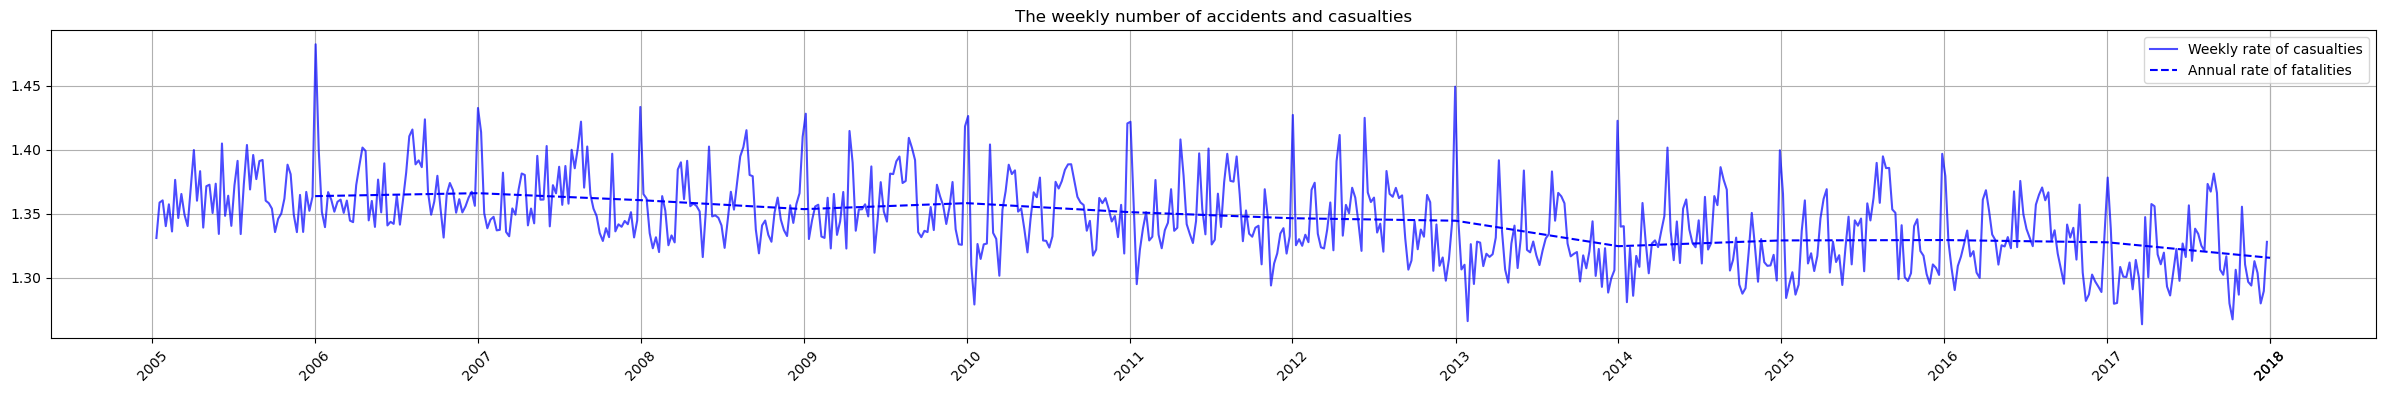

In [291]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(30,4)
ax.plot(weekly_df['end_timestamp'], weekly_df["number_of_casualties"]/weekly_df["number_of_accidents"], color="blue", label="Weekly rate of casualties", linestyle="-",alpha=0.7)
ax.plot(yearly_df['end_timestamp'], yearly_df["number_of_casualties"]/yearly_df["number_of_accidents"], color="blue", label="Annual rate of fatalities", linestyle="--")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
unique_years = np.sort(np.append(monthly_df['end_timestamp'].dt.year.unique(),2018))
plt.xticks(ticks=pd.to_datetime(unique_years, format='%Y'), labels=unique_years)
plt.title('The weekly number of accidents and casualties')
plt.legend()
plt.grid()
plt.show()